In [2]:
%pip install netCDF4 h5netcdf xarray pandas "numpy<2" matplotlib seaborn packaging scipy store statsmodels plotly nbformat pmdarima


You should consider upgrading via the '/usr/local/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data = pd.read_csv("mp_conc_weekly_full.csv")
data = pd.read_csv("mp_conc_weekly_full.csv")
data = data.set_index('time')
data.index = pd.to_datetime(data.index)
data

,mp_concentration
time,
2018-08-19,14.865665
2018-08-26,14.803406
2018-09-02,14.709439
2018-09-09,14.761217
2018-09-16,14.808359
...,...
2025-05-11,14.521454
2025-05-18,14.560788
2025-05-25,14.642275


In [6]:
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

## Data Loading

In [3]:
# Assuming your .nc file is named 'microplastic_data.nc'
ds = xr.open_dataset('/Users/autinauyeung/arima-mircoplastic/data/cyg.ddmi.s20180816-120000-e20180816-120000.l3.grid-microplastic.a32.d33.nc', engine='netcdf4')
ds = ds.to_dataframe().reset_index()
ds = ds.dropna()
ds

,lat,lon,time,num_mp_samples,stddev_mp_samples,mp_concentration
0,-37.0,0.00,2018-08-16 12:00:00,817.0,0.135344,12866.504883
1,-37.0,0.25,2018-08-16 12:00:00,814.0,0.130202,12746.297852
2,-37.0,0.50,2018-08-16 12:00:00,812.0,0.125060,12626.090820
3,-37.0,0.75,2018-08-16 12:00:00,810.0,0.119918,12505.883789
4,-37.0,1.00,2018-08-16 12:00:00,808.0,0.114776,12385.675781
...,...,...,...,...,...,...
427675,37.0,358.75,2018-08-16 12:00:00,378.0,0.164024,13963.895508
427676,37.0,359.00,2018-08-16 12:00:00,472.0,0.162074,14053.669922
427677,37.0,359.25,2018-08-16 12:00:00,522.0,0.162901,13929.945312
427678,37.0,359.50,2018-08-16 12:00:00,572.0,0.163729,13806.220703


## Data Processing

Single File Investigation 

Investigation Area: 
Latitutde: -30.5 and 17.25 
Longitutde: 72 and 215.25 

In [4]:
subset = ds.where(
    (ds['lat'] >= -30.5) & (ds['lat'] <= 17.25) &
    (ds['lon'] >= 72) & (ds['lon'] <= 215.25)).dropna()
subset

,lat,lon,time,num_mp_samples,stddev_mp_samples,mp_concentration
37728,-30.50,72.00,2018-08-16 12:00:00,923.0,0.183145,12876.937500
37729,-30.50,72.25,2018-08-16 12:00:00,913.0,0.183003,12908.672852
37730,-30.50,72.50,2018-08-16 12:00:00,903.0,0.182860,12940.408203
37731,-30.50,72.75,2018-08-16 12:00:00,893.0,0.182717,12972.144531
37732,-30.50,73.00,2018-08-16 12:00:00,884.0,0.182575,13003.879883
...,...,...,...,...,...,...
313337,17.25,214.25,2018-08-16 12:00:00,861.0,0.141743,12359.061523
313338,17.25,214.50,2018-08-16 12:00:00,832.0,0.142005,12329.065430
313339,17.25,214.75,2018-08-16 12:00:00,803.0,0.142266,12299.068359
313340,17.25,215.00,2018-08-16 12:00:00,774.0,0.142528,12269.072266


In [5]:
total_mp = subset['mp_concentration'].sum()
print(total_mp)

1245180000.0


In [6]:
lat_min, lat_max = -30.5, 17.25
lon_min, lon_max = 72, 215.25

# Area in degrees^2
area_deg2 = (lat_max - lat_min) * (lon_max - lon_min)

# Area in km^2 (approximate, using mean latitude)
mean_lat = (lat_min + lat_max) / 2
lat_km = 111 * (lat_max - lat_min)
lon_km = 111 * np.cos(np.deg2rad(mean_lat)) * (lon_max - lon_min)
area_km2 = lat_km * lon_km

print(area_km2)

83715185.88151443


In [7]:
avg_mp = total_mp / area_km2
print(avg_mp)

14.87400426682866


In [8]:
type(subset['time'])

pandas.core.series.Series

In [9]:
date = pd.to_datetime(subset['time'].values[0]).date()
print(date)

2018-08-16


Load more data

In [10]:
import os
from tqdm import tqdm


lat_min, lat_max = -30.5, 17.25
lon_min, lon_max = 72, 215.25

mean_lat = (lat_min + lat_max) / 2
lat_km = 111 * (lat_max - lat_min)
lon_km = 111 * np.cos(np.deg2rad(mean_lat)) * (lon_max - lon_min)
area_km2 = lat_km * lon_km

results = []

data_folder = 'data'

files = [file for file in os.listdir(data_folder)]


In [11]:
len(files)

2488

In [12]:
for file in tqdm(files, desc='Processing NetCDF files'):
    if file.endswith('.nc'):
        file_path=os.path.join(data_folder, file)
        ds = xr.open_dataset(file_path)
        ds = ds.to_dataframe().reset_index()
        ds = ds.dropna()

        subset = ds.where(
            (ds['lat'] >= lat_min) & (ds['lat'] <= lat_max) &
            (ds['lon'] >= lon_min) & (ds['lon'] <= lon_max)).dropna()

        total_mp = subset['mp_concentration'].sum()

        avg_mp = total_mp / area_km2

        date = pd.to_datetime(subset['time'].values[0]).date()

        results.append({'time': date, 'mp_concentration': avg_mp})

results 

Processing NetCDF files: 100%|██████████| 2488/2488 [05:24<00:00,  7.68it/s]


[{'time': datetime.date(2021, 11, 25), 'mp_concentration': 14.547681823506794},
 {'time': datetime.date(2021, 8, 24), 'mp_concentration': 14.624168209251222},
 {'time': datetime.date(2024, 12, 1), 'mp_concentration': 14.55926089353803},
 {'time': datetime.date(2024, 5, 13), 'mp_concentration': 14.696244976882605},
 {'time': datetime.date(2025, 2, 24), 'mp_concentration': 14.605490021016495},
 {'time': datetime.date(2020, 10, 31), 'mp_concentration': 14.661264656775035},
 {'time': datetime.date(2020, 9, 30), 'mp_concentration': 14.600078911965849},
 {'time': datetime.date(2018, 9, 28), 'mp_concentration': 14.73309066942357},
 {'time': datetime.date(2018, 10, 29), 'mp_concentration': 14.742376248758008},
 {'time': datetime.date(2020, 7, 23), 'mp_concentration': 14.74343431246613},
 {'time': datetime.date(2024, 3, 30), 'mp_concentration': 14.522184322933587},
 {'time': datetime.date(2025, 4, 7), 'mp_concentration': 14.736202171802226},
 {'time': datetime.date(2020, 11, 23), 'mp_concentrat

In [13]:
df = pd.DataFrame(results)
df = df.sort_values('time').reset_index().drop(columns=['index'])
df.to_csv("mp_conc_full.csv", index=False)
df

,time,mp_concentration
0,2018-08-16,14.874004
1,2018-08-17,14.868096
2,2018-08-18,14.865804
3,2018-08-19,14.854756
4,2018-08-20,14.843458
...,...,...
2481,2025-06-01,14.724918
2482,2025-06-02,14.717412
2483,2025-06-03,14.719857
2484,2025-06-04,14.722201


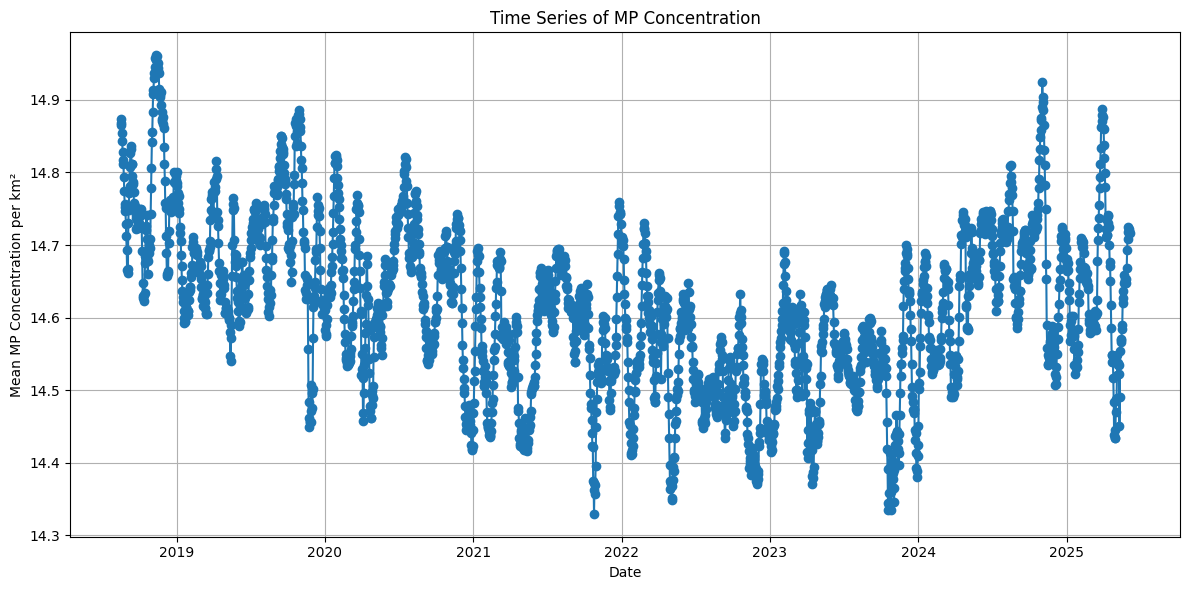

In [14]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['mp_concentration'], marker='o')
plt.xlabel('Date')
plt.ylabel('Mean MP Concentration per km²')
plt.title('Time Series of MP Concentration')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
df

,mp_concentration
time,
2018-08-16,14.874004
2018-08-17,14.868096
2018-08-18,14.865804
2018-08-19,14.854756
2018-08-20,14.843458
...,...
2025-06-01,14.724918
2025-06-02,14.717412
2025-06-03,14.719857


In [16]:
weekly_df = df.resample('W').mean()
weekly_df.dropna()
weekly_df.to_csv('mp_conc_weekly_full.csv')
weekly_df

,mp_concentration
time,
2018-08-19,14.865665
2018-08-26,14.803406
2018-09-02,14.709439
2018-09-09,14.761217
2018-09-16,14.808359
...,...
2025-05-11,14.521454
2025-05-18,14.560788
2025-05-25,14.642275


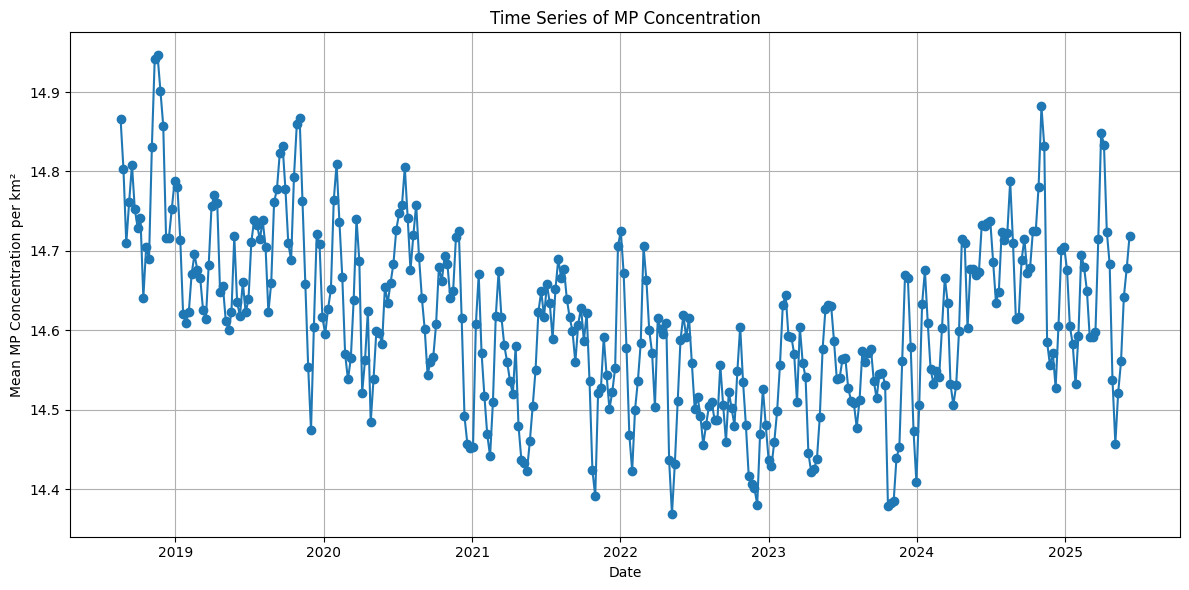

In [17]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(weekly_df.index, weekly_df['mp_concentration'], marker='o')
plt.xlabel('Date')
plt.ylabel('Mean MP Concentration per km²')
plt.title('Time Series of MP Concentration')
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
monthly_df = df.resample('M').mean()
monthly_df.dropna()
monthly_df.to_csv('mp_conc_monthly_full.csv')

/var/folders/j9/ndmp7tg95qjck81gbd4gdfy00000gn/T/ipykernel_49340/3034867834.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.resample('M').mean()


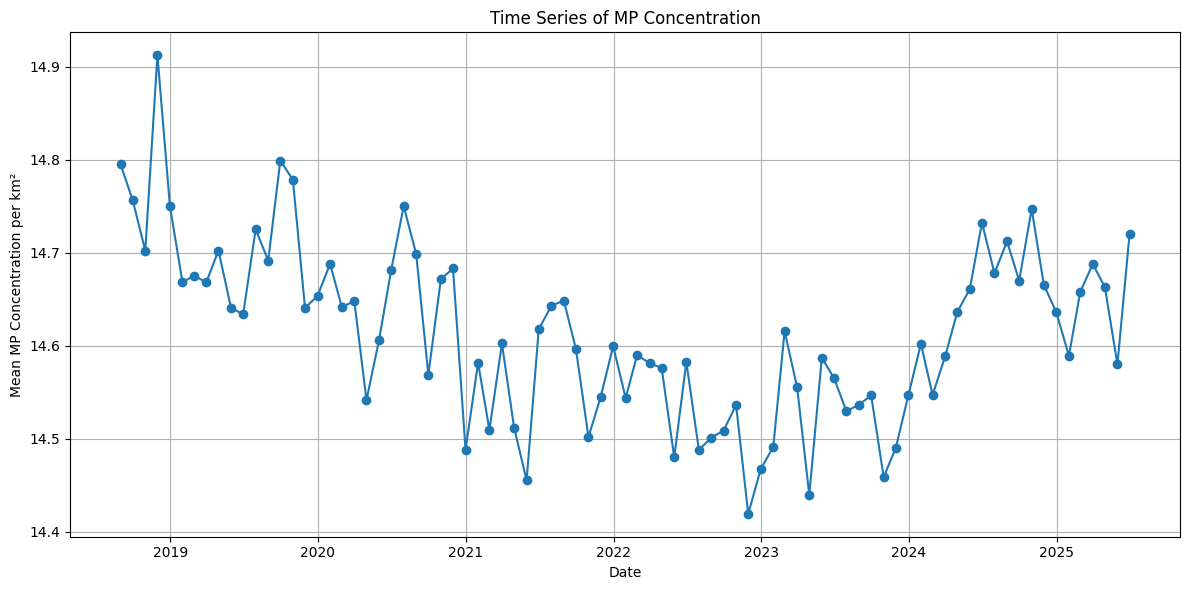

In [19]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_df.index, monthly_df['mp_concentration'], marker='o')
plt.xlabel('Date')
plt.ylabel('Mean MP Concentration per km²')
plt.title('Time Series of MP Concentration')
plt.grid(True)
plt.tight_layout()
plt.show()

## Stationarity 

In [3]:
data = pd.read_csv("mp_conc_weekly_full.csv")
data

,time,mp_concentration
0,2018-08-19,14.865665
1,2018-08-26,14.803406
2,2018-09-02,14.709439
3,2018-09-09,14.761217
4,2018-09-16,14.808359
...,...,...
351,2025-05-11,14.521454
352,2025-05-18,14.560788
353,2025-05-25,14.642275
354,2025-06-01,14.677809


In [26]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    test_results = adfuller(series)
    print("ADF Statistic: ", test_results[0])
    print("p-value: ", test_results[1])
    print("Critical values: ")
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))

adf_test(data['mp_concentration'][:])

ADF Statistic:  -2.7702578684698795
p-value:  0.06264941543608522
Critical values: 
	1%: -3.45
	5%: -2.87
	10%: -2.57


Since p-value (0.06) is greater than significance level (0.05), we are going to test different transformation method to see how the autocorrelation plot look like. 

In [27]:
def plot_graph(df: pd.DataFrame, y: str):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[y], marker='o')
    plt.xlabel('Date')
    plt.ylabel('Mean MP Concentration per km²')
    plt.title('Time Series of '+ y)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [28]:
from scipy.stats import boxcox

data['mp_conc_boxcox'], lam = boxcox(data['mp_concentration'])
data['mp_conc_diff'] = data['mp_concentration'].diff()
data['mp_conc_diff_diff'] = data['mp_concentration'].diff().diff()
data['mp_conc_log'] = np.log(data['mp_concentration'])
data['mp_conc_logndiff'] = data['mp_conc_log'].diff()
data

,time,mp_concentration,mp_conc_boxcox,mp_conc_diff,mp_conc_diff_diff,mp_conc_log,mp_conc_logndiff
0,2018-08-19,14.865665,0.124086,NaN,NaN,2.699054,NaN
1,2018-08-26,14.803406,0.124086,-0.062259,NaN,2.694857,-0.004197
2,2018-09-02,14.709439,0.124086,-0.093968,-0.031709,2.688489,-0.006368
3,2018-09-09,14.761217,0.124086,0.051778,0.145746,2.692003,0.003514
4,2018-09-16,14.808359,0.124086,0.047142,-0.004636,2.695192,0.003189
...,...,...,...,...,...,...,...
351,2025-05-11,14.521454,0.124086,0.064265,0.144386,2.675627,0.004435
352,2025-05-18,14.560788,0.124086,0.039334,-0.024931,2.678332,0.002705
353,2025-05-25,14.642275,0.124086,0.081487,0.042153,2.683913,0.005581
354,2025-06-01,14.677809,0.124086,0.035534,-0.045953,2.686337,0.002424


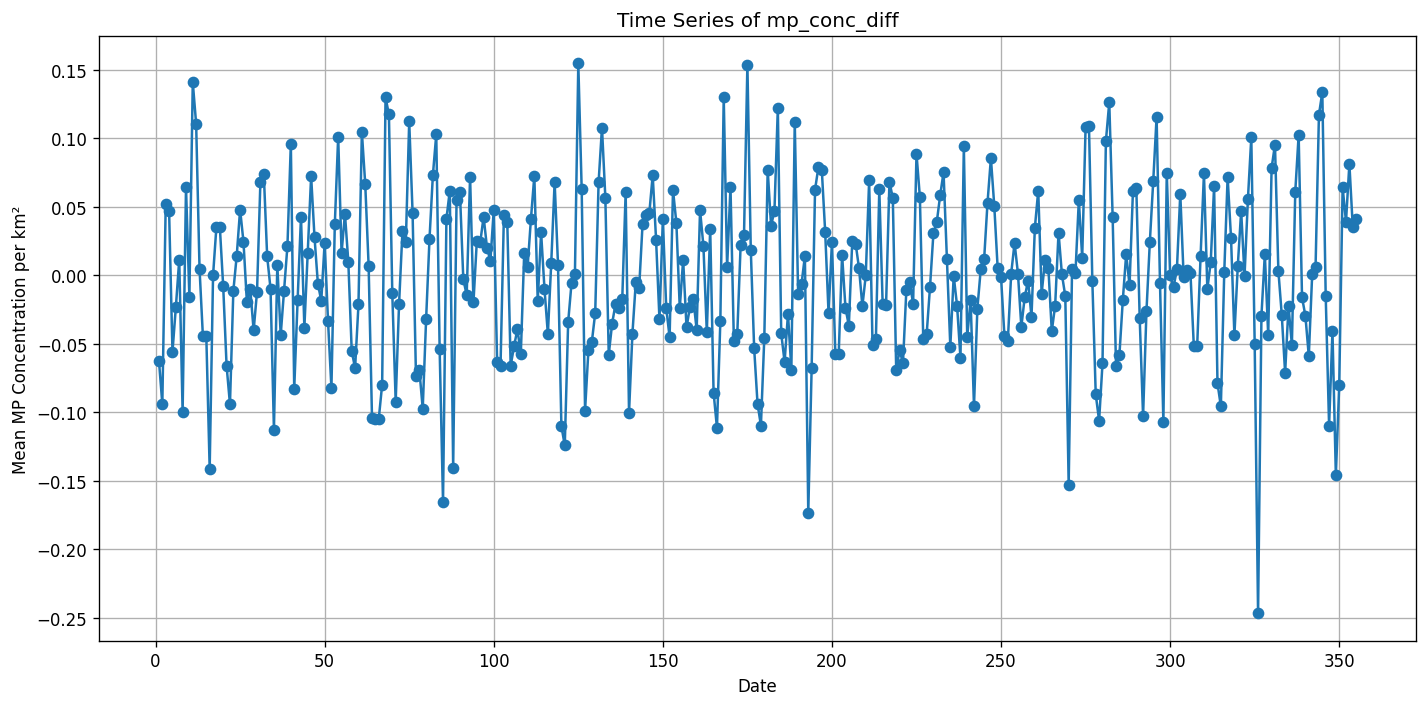

ADF Statistic:  -7.235427836011408
p-value:  1.9452064351259605e-10
Critical values: 
	1%: -3.45
	5%: -2.87
	10%: -2.57


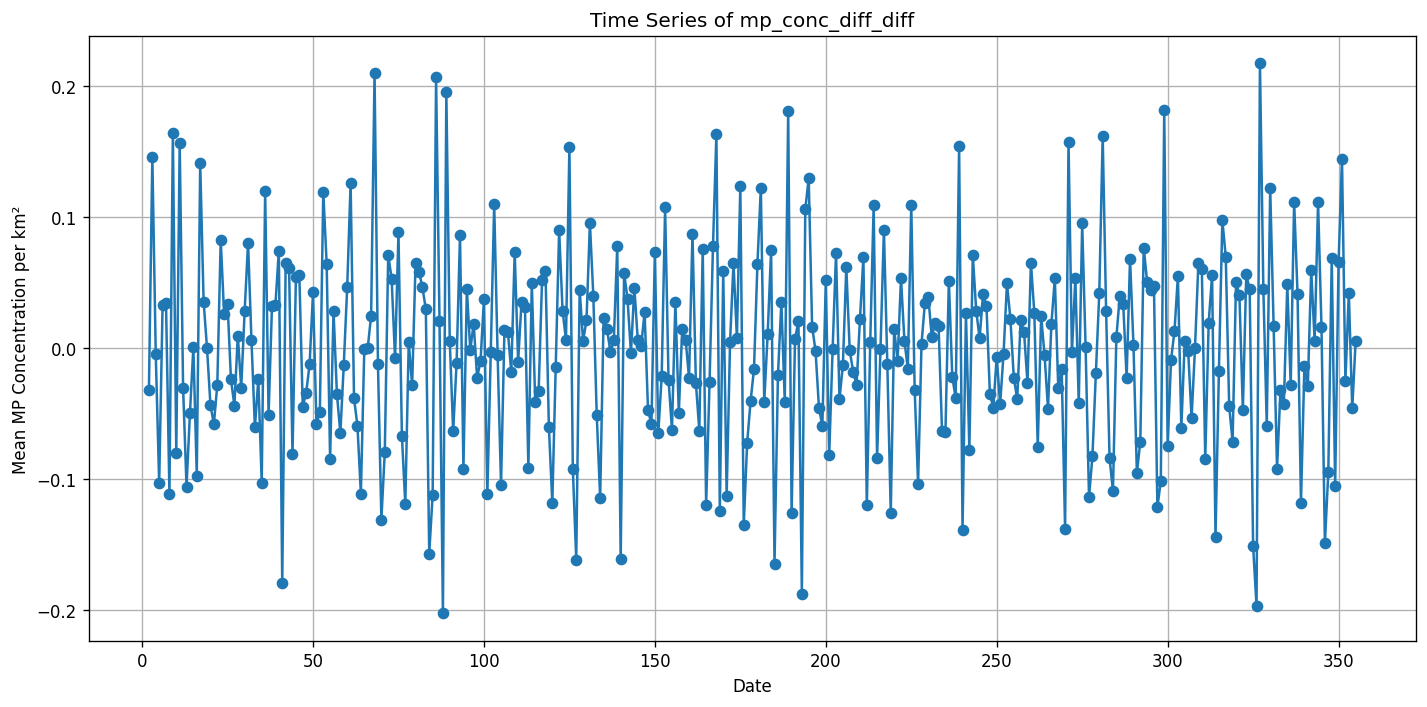

ADF Statistic:  -9.04179747196767
p-value:  5.109918540300535e-15
Critical values: 
	1%: -3.45
	5%: -2.87
	10%: -2.57


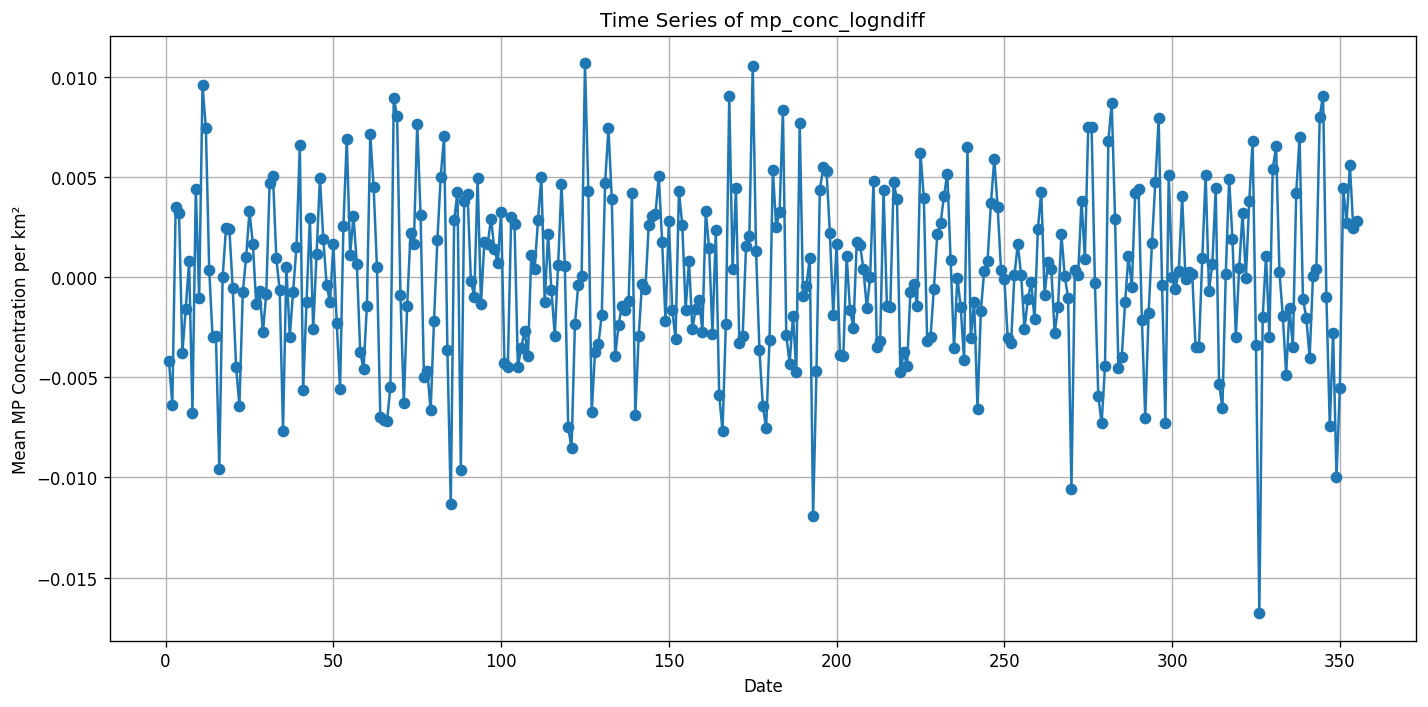

ADF Statistic:  -7.235250484078229
p-value:  1.9471700783829095e-10
Critical values: 
	1%: -3.45
	5%: -2.87
	10%: -2.57


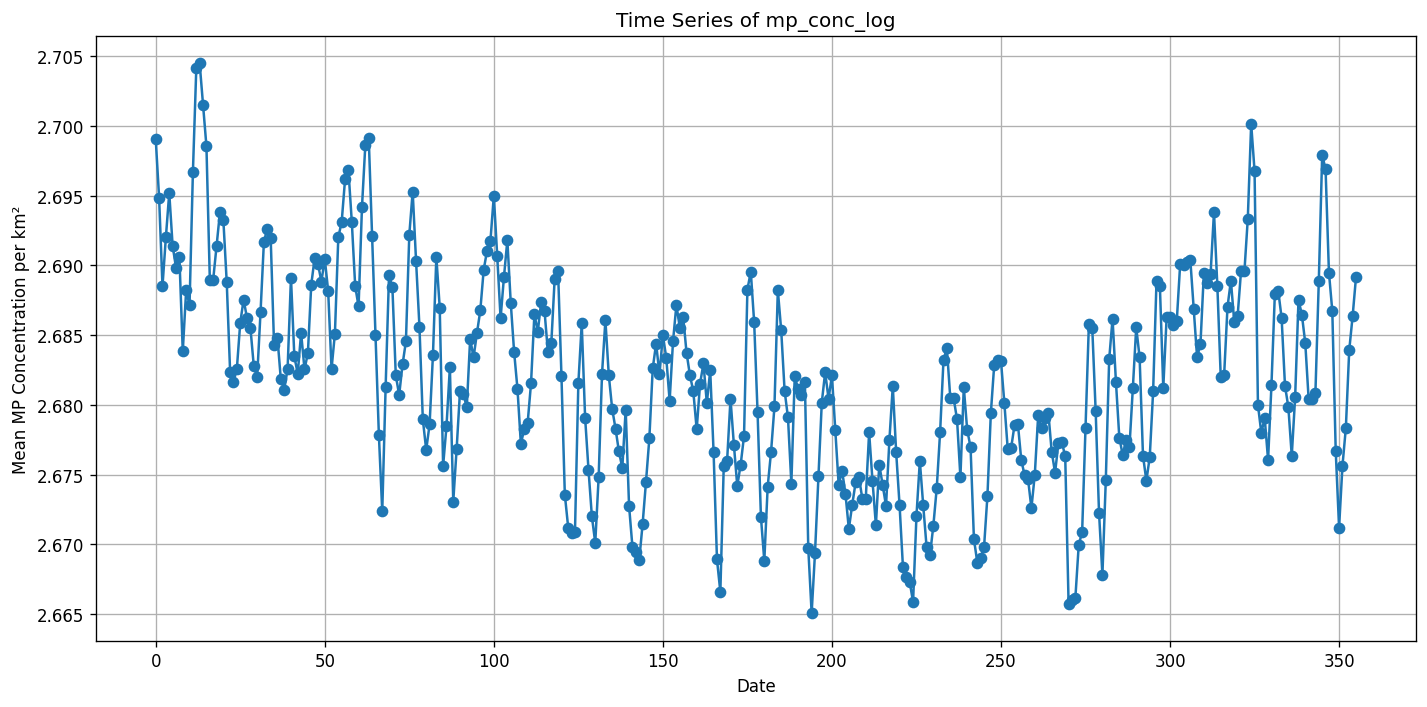

ADF Statistic:  -2.760619199803417
p-value:  0.06412293773659176
Critical values: 
	1%: -3.45
	5%: -2.87
	10%: -2.57


In [29]:
plot_graph(data, 'mp_conc_diff')
adf_test(data['mp_conc_diff'][1:])
plot_graph(data, 'mp_conc_diff_diff')
adf_test(data['mp_conc_diff_diff'][2:])
plot_graph(data, 'mp_conc_logndiff')
adf_test(data['mp_conc_logndiff'][1:])
plot_graph(data, 'mp_conc_log')
adf_test(data['mp_conc_log'][:])



A differencing of 1 is enough to achieve stationary in this dataset. 

The distribution itself is normal enough given the initial ADF test on microplastic data. All we need is to remove seasonality and perhaps assess the necesscity of doing logarithmic transform. 

## Decomposition

In [30]:
data = data.set_index('time')

In [31]:
data.dropna()

,mp_concentration,mp_conc_boxcox,mp_conc_diff,mp_conc_diff_diff,mp_conc_log,mp_conc_logndiff
time,,,,,,
2018-09-02,14.709439,0.124086,-0.093968,-0.031709,2.688489,-0.006368
2018-09-09,14.761217,0.124086,0.051778,0.145746,2.692003,0.003514
2018-09-16,14.808359,0.124086,0.047142,-0.004636,2.695192,0.003189
2018-09-23,14.752451,0.124086,-0.055907,-0.103049,2.691409,-0.003783
2018-09-30,14.729223,0.124086,-0.023228,0.032679,2.689834,-0.001576
...,...,...,...,...,...,...
2025-05-11,14.521454,0.124086,0.064265,0.144386,2.675627,0.004435
2025-05-18,14.560788,0.124086,0.039334,-0.024931,2.678332,0.002705
2025-05-25,14.642275,0.124086,0.081487,0.042153,2.683913,0.005581


In [32]:
data.index = pd.to_datetime(data.index)
data

,mp_concentration,mp_conc_boxcox,mp_conc_diff,mp_conc_diff_diff,mp_conc_log,mp_conc_logndiff
time,,,,,,
2018-08-19,14.865665,0.124086,NaN,NaN,2.699054,NaN
2018-08-26,14.803406,0.124086,-0.062259,NaN,2.694857,-0.004197
2018-09-02,14.709439,0.124086,-0.093968,-0.031709,2.688489,-0.006368
2018-09-09,14.761217,0.124086,0.051778,0.145746,2.692003,0.003514
2018-09-16,14.808359,0.124086,0.047142,-0.004636,2.695192,0.003189
...,...,...,...,...,...,...
2025-05-11,14.521454,0.124086,0.064265,0.144386,2.675627,0.004435
2025-05-18,14.560788,0.124086,0.039334,-0.024931,2.678332,0.002705
2025-05-25,14.642275,0.124086,0.081487,0.042153,2.683913,0.005581


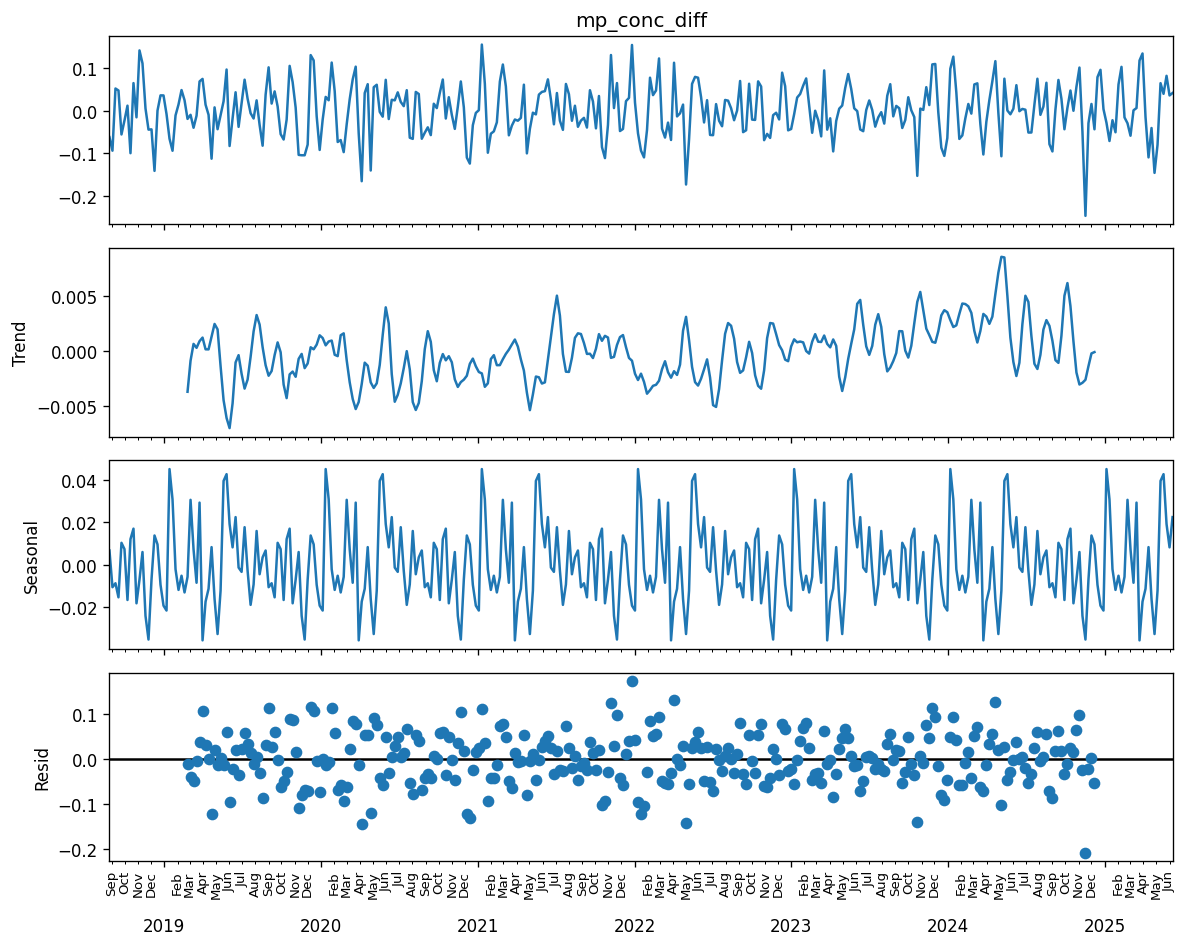

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

decomposition_plot_add = seasonal_decompose(data['mp_conc_diff'][1:],
                                            model='additive')
fig = decomposition_plot_add.plot()
fig.set_size_inches(10,8)

date_format = mdates.DateFormatter('%Y-%m') # Define the format: Year-Month

for ax in fig.axes:
    ax.xaxis.set_major_formatter(date_format)
    
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center") 

    ax.tick_params(axis='x', which='major', pad=30)

    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b')) 
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=90, fontsize=8) 

plt.tight_layout()
plt.show()


## ACF & PACF

In [34]:
data = data.dropna()
data

,mp_concentration,mp_conc_boxcox,mp_conc_diff,mp_conc_diff_diff,mp_conc_log,mp_conc_logndiff
time,,,,,,
2018-09-02,14.709439,0.124086,-0.093968,-0.031709,2.688489,-0.006368
2018-09-09,14.761217,0.124086,0.051778,0.145746,2.692003,0.003514
2018-09-16,14.808359,0.124086,0.047142,-0.004636,2.695192,0.003189
2018-09-23,14.752451,0.124086,-0.055907,-0.103049,2.691409,-0.003783
2018-09-30,14.729223,0.124086,-0.023228,0.032679,2.689834,-0.001576
...,...,...,...,...,...,...
2025-05-11,14.521454,0.124086,0.064265,0.144386,2.675627,0.004435
2025-05-18,14.560788,0.124086,0.039334,-0.024931,2.678332,0.002705
2025-05-25,14.642275,0.124086,0.081487,0.042153,2.683913,0.005581


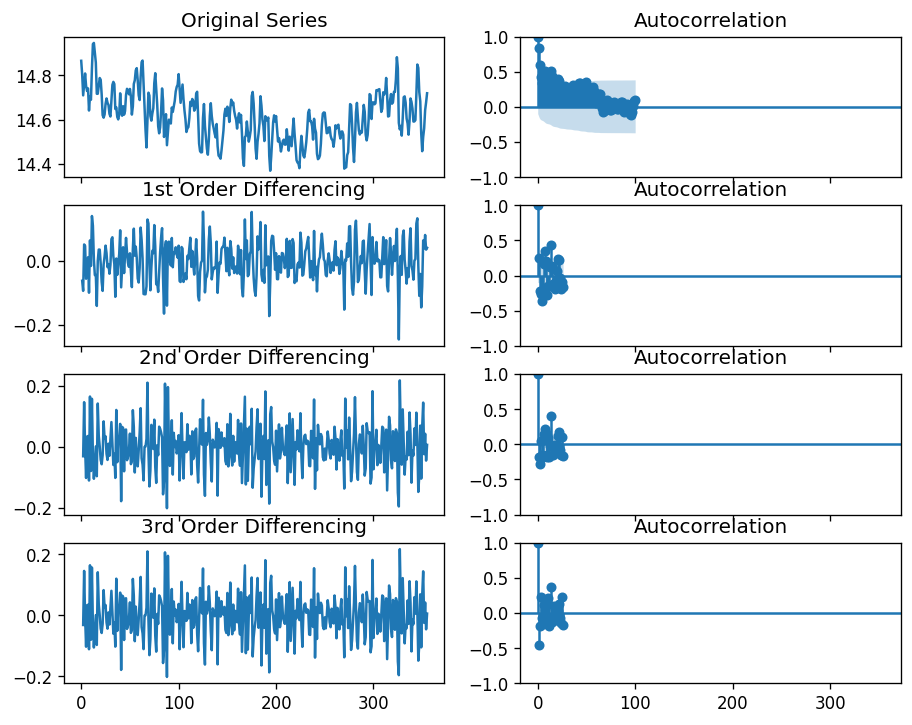

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(data.mp_concentration); axes[0, 0].set_title('Original Series')
plot_acf(data.mp_concentration, ax=axes[0, 1], lags=100)

# 1st Differencing
axes[1, 0].plot(data.mp_concentration.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.mp_concentration.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data.mp_concentration.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.mp_concentration.diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(data.mp_concentration.diff().diff()); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(data.mp_concentration.diff().diff().diff().dropna(), ax=axes[3, 1])

plt.show()

based on the above data, differencing (d) can be tested between 1 and 2

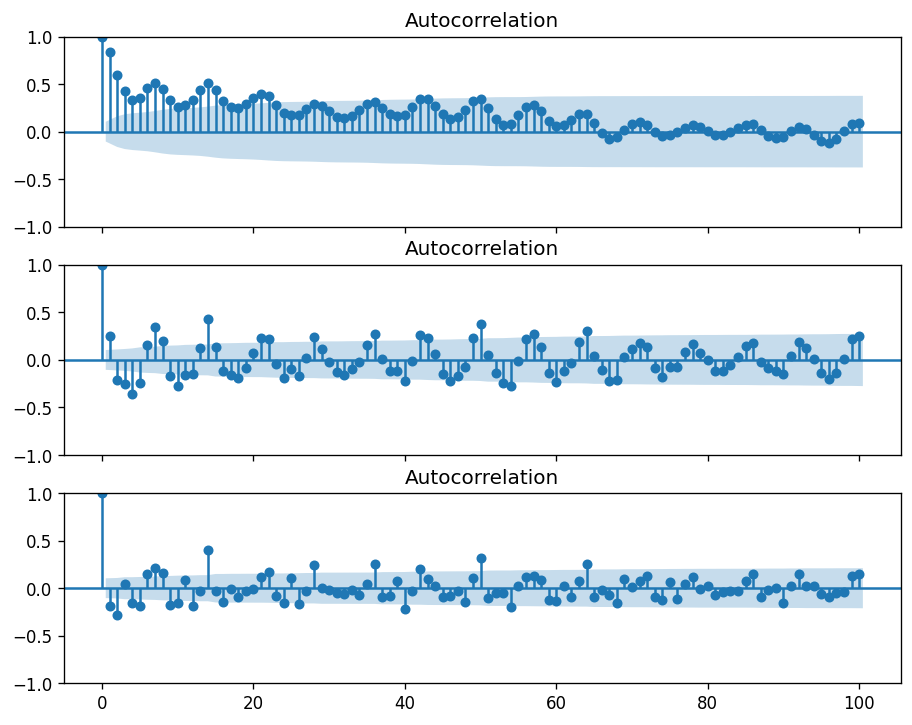

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
fig, axes = plt.subplots(3, 1, sharex=True)
plot_acf(data['mp_concentration'], lags=100, ax=axes[0])
plot_acf(data['mp_concentration'].diff().dropna(), lags=100, ax=axes[1])
plot_acf(data['mp_concentration'].diff().diff().dropna(), lags=100, ax=axes[2])
plt.show()

Based on the above data, we can set the MA term (q) to 

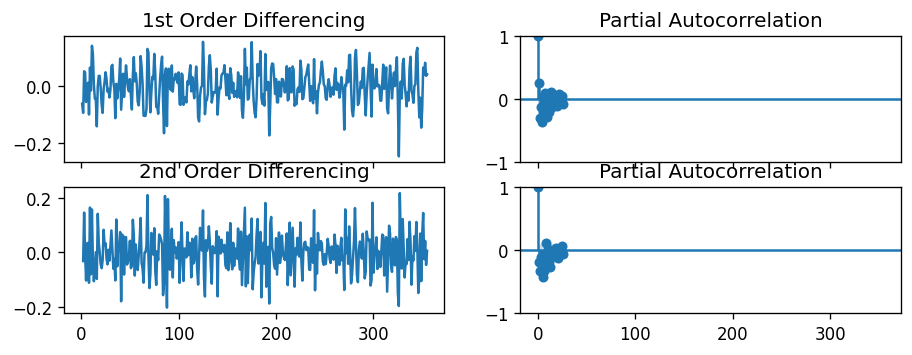

In [8]:
# PACF plot of 1st differenced series
from statsmodels.graphics.tsaplots import plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(2, 2, sharex=True)

# 1st Differencing
axes[0, 0].plot(data.mp_concentration.diff()); axes[0, 0].set_title('1st Order Differencing')
plot_pacf(data.mp_concentration.diff().dropna(), ax=axes[0, 1])

# 2nd Differencing
axes[1, 0].plot(data.mp_concentration.diff().diff()); axes[1, 0].set_title('2nd Order Differencing')
plot_pacf(data.mp_concentration.diff().diff().dropna(), ax=axes[1, 1])

plt.show()

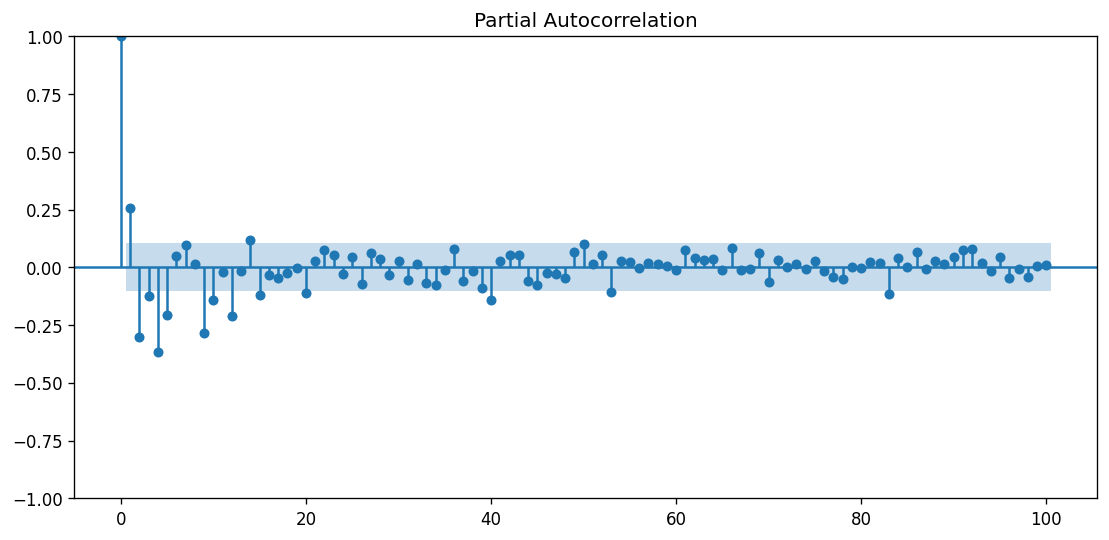

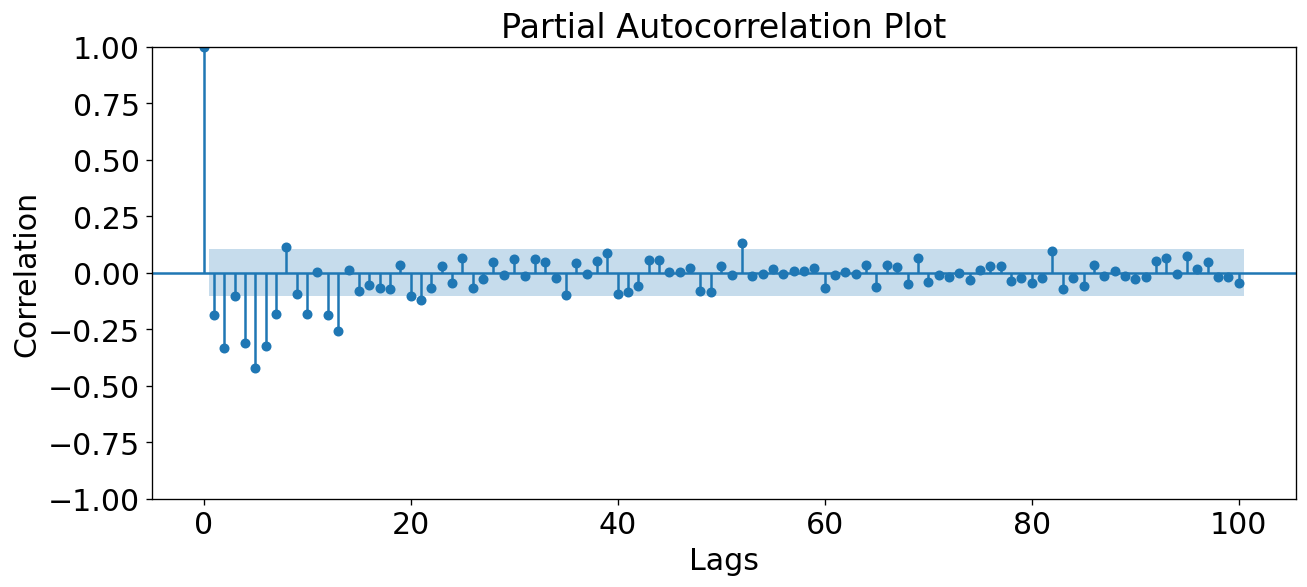

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf
# Plot partial autocorrelation
plt.rc("figure", figsize=(11,5))
plot_pacf(data.mp_concentration.diff().dropna(), method='ywm', lags=100)
plot_pacf(data.mp_concentration.diff().diff().dropna(), method='ywm', lags=100)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Partial Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
# data = data.drop(['mp_conc_diff'],axis=1)
data = data.drop(['mp_conc_diff_diff'],axis=1)
data = data.drop(['mp_conc_log'],axis=1)
data = data.drop(['mp_conc_logndiff'],axis=1)
data = data.drop(['mp_conc_boxcox'],axis=1)
data

## ARIMA

In [6]:
import pandas as pd 
data = pd.read_csv("mp_conc_weekly_full.csv")
data = data.set_index('time')
data.index = pd.to_datetime(data.index)
data

,mp_concentration
time,
2018-08-19,14.865665
2018-08-26,14.803406
2018-09-02,14.709439
2018-09-09,14.761217
2018-09-16,14.808359
...,...
2025-05-11,14.521454
2025-05-18,14.560788
2025-05-25,14.642275


In [7]:
from statsmodels.tsa.arima.model import ARIMA

train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

model = ARIMA(train.mp_concentration, order=(13,2,14)).fit()
print(model.summary())


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:       mp_concentration   No. Observations:                  285
Model:               ARIMA(13, 2, 14)   Log Likelihood                 480.618
Date:                Fri, 18 Jul 2025   AIC                           -905.235
Time:                        11:33:01   BIC                           -803.163
Sample:                    08-19-2018   HQIC                          -864.308
                         - 01-28-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8327      1.141     -0.730      0.465      -3.069       1.403
ar.L2         -0.6977      1.585     -0.440      0.660      -3.804       2.409
ar.L3         -0.6177      1.001     -0.617      0.5

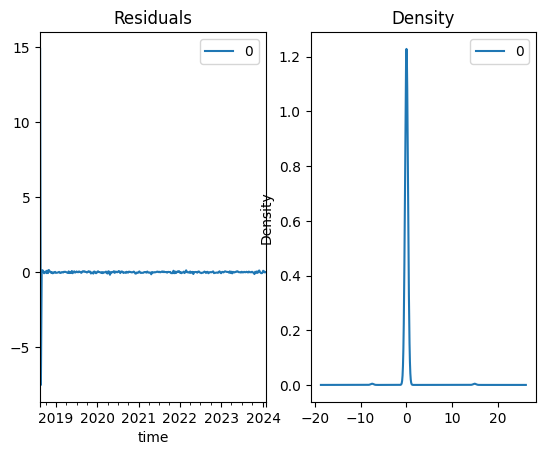

In [10]:
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters

                               SARIMAX Results                                
Dep. Variable:       mp_concentration   No. Observations:                  285
Model:               ARIMA(13, 1, 14)   Log Likelihood                 485.093
Date:                Fri, 18 Jul 2025   AIC                           -914.187
Time:                        11:33:36   BIC                           -812.015
Sample:                    08-19-2018   HQIC                          -873.224
                         - 01-28-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0677     11.266     -0.006      0.995     -22.148      22.013
ar.L2         -0.6051      2.162     -0.280      0.780      -4.843       3.633
ar.L3         -0.0555      7.605     -0.007      0.9

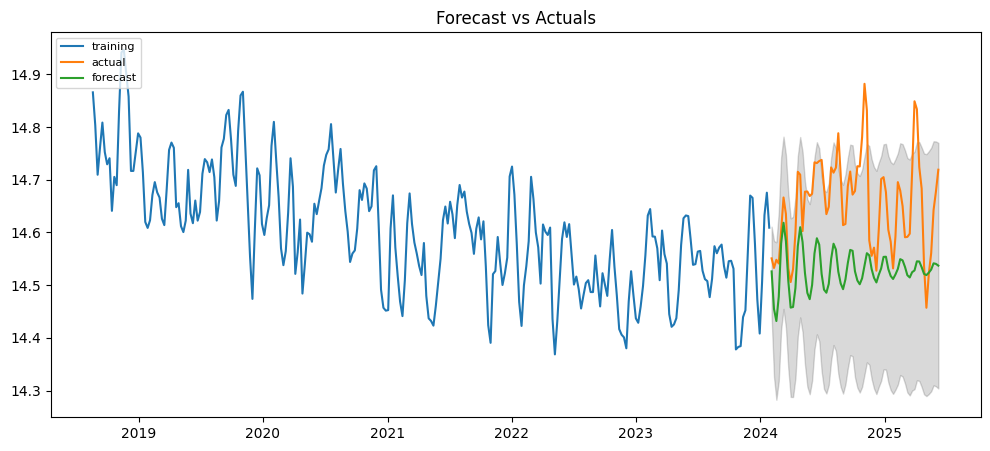

In [ ]:
model = ARIMA(train.mp_concentration, order=(13,1,14)).fit()
print(model.summary())

# Forecast
fc = model.get_forecast(len(test))
forecasts = fc.predicted_mean
conf = fc.conf_int()

lower_series = conf['lower mp_concentration']
upper_series = conf['upper mp_concentration']

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.index, train.mp_concentration, label='training')
plt.plot(test.index, test.mp_concentration, label='actual')
plt.plot(test.index, forecasts, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [13]:
forecasts

2024-02-04    14.526162
2024-02-11    14.454813
2024-02-18    14.432067
2024-02-25    14.478194
2024-03-03    14.579169
                ...    
2025-05-11    14.523754
2025-05-18    14.529654
2025-05-25    14.541467
2025-06-01    14.540400
2025-06-08    14.537075
Freq: W-SUN, Name: predicted_mean, Length: 71, dtype: float64

In [14]:
test.mp_concentration

time
2024-02-04    14.550875
2024-02-11    14.532674
2024-02-18    14.548169
2024-02-25    14.541131
2024-03-03    14.602452
                ...    
2025-05-11    14.521454
2025-05-18    14.560788
2025-05-25    14.642275
2025-06-01    14.677809
2025-06-08    14.718995
Name: mp_concentration, Length: 71, dtype: float64

In [15]:
from statsmodels.tsa.stattools import acf
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr})

forecast_accuracy(forecasts, test.mp_concentration)

{'mape': 0.008629824724805104,
 'me': -0.12506237822835145,
 'mae': 0.12687122630669148,
 'mpe': -0.008504727006759326,
 'rmse': 0.14861604907104653,
 'corr': 0.4033996413872764}

## Auto-SARIMA

In [16]:
%pip install pmdarima

You should consider upgrading via the '/usr/local/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [19]:
import pmdarima as pm 
# The best practice search space
smodel = pm.auto_arima(train,
                       start_p=0, start_q=0,
                       max_p=3, max_q=3,   # Search for non-seasonal p, q up to 3
                       m=12,               # Set the seasonal period to 12
                       start_P=0, start_Q=0,
                       max_P=2, max_Q=2,   # Search for seasonal P, Q up to 2
                       d=None, D=1,        # Let it find non-seasonal d, but enforce seasonal D=1
                       seasonal=True,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

smodel.summary()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/pytho

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-362.790, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-623.889, Time=0.37 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-363.451, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-570.907, Time=0.08 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-756.950, Time=1.08 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=-756.194, Time=2.25 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.97 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-495.475, Time=0.59 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-797.117, Time=1.35 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-678.507, Time=0.58 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=-802.852, Time=2.46 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.99 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=3.29 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=3.08 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(2,1,1)[12] intercept   : AIC=-802.792, Time=3.14 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,1,1)[12] intercept   : AIC=-804.367, Time=2.92 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.19 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=-796.374, Time=2.21 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,1,2)[12] intercept   : AIC=inf, Time=3.45 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=-677.638, Time=0.93 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=3.11 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=-803.738, Time=2.87 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=4.49 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,1,1)[12] intercept   : AIC=-797.851, Time=3.25 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,1,1)[12] intercept   : AIC=-798.725, Time=2.85 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(2,1,1)[12] intercept   : AIC=-796.112, Time=4.21 sec


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,1,1)[12]             : AIC=-795.096, Time=2.95 sec

Best model:  ARIMA(2,0,1)(2,1,1)[12] intercept
Total fit time: 55.455 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  285
Model:             SARIMAX(2, 0, 1)x(2, 1, 1, 12)   Log Likelihood                 410.183
Date:                            Fri, 18 Jul 2025   AIC                           -804.367
Time:                                    11:48:59   BIC                           -775.491
Sample:                                08-19-2018   HQIC                          -792.776
                                     - 01-28-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0067      0.002     -3.982      0.000      -0.010      -0.003
ar.L1          0.7296      0.133      5.481      0.000       0.469       0.991
ar.L2         -0.1428      0.118     -1.215      0.224      -0.373       0.088
ma.L1          0.3948      0.126      3.130      0.002       0.148       0.642
ar.S.L12      -0.2255      0.077     -2.927      0.003      -0.377      -0.075
ar.S.L24      -0.3359      0.072     -4.634      0.000      -0.478      -0.194
ma.S.L12      -0.8252      0.074    -11.129      0.000      -0.970      -0.680
sigma2         0.0026      0.000     12.073      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.35
Prob(Q):                              0.91   Prob(JB):                         0.31
Heteroskedasticity (H):               0.68   Skew:                            -0.18
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
n_periods = len(test)
forecasts, conf_int = smodel.predict(n_periods=n_periods, return_conf_int=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [27]:
conf_int

array([[14.44319643, 14.64369155],
       [14.35101834, 14.65271478],
       [14.30524713, 14.63611536],
       [14.26708817, 14.60465389],
       [14.26070406, 14.59954939],
       [14.26970011, 14.60875462],
       [14.27529508, 14.61437927],
       [14.28339805, 14.62248588],
       [14.28550328, 14.6245915 ],
       [14.31410255, 14.65319079],
       [14.31906626, 14.6581545 ],
       [14.32540298, 14.66449121],
       [14.33497074, 14.67421088],
       [14.32155044, 14.66098226],
       [14.30068345, 14.64018396],
       [14.26839988, 14.60791649],
       [14.25267684, 14.59219672],
       [14.26259956, 14.60211997],
       [14.28940359, 14.62892408],
       [14.30311984, 14.64264034],
       [14.28886635, 14.62838686],
       [14.24568058, 14.58520108],
       [14.24637998, 14.58590048],
       [14.25917168, 14.59869217],
       [14.29165986, 14.63250279],
       [14.28946379, 14.63197127],
       [14.31284263, 14.65595217],
       [14.32832294, 14.67157819],
       [14.31531186,

In [26]:
conf_int[:,0]

array([14.44319643, 14.35101834, 14.30524713, 14.26708817, 14.26070406,
       14.26970011, 14.27529508, 14.28339805, 14.28550328, 14.31410255,
       14.31906626, 14.32540298, 14.33497074, 14.32155044, 14.30068345,
       14.26839988, 14.25267684, 14.26259956, 14.28940359, 14.30311984,
       14.28886635, 14.24568058, 14.24637998, 14.25917168, 14.29165986,
       14.28946379, 14.31284263, 14.32832294, 14.31531186, 14.29281533,
       14.27730787, 14.26542769, 14.2870615 , 14.29292805, 14.30727466,
       14.29417719, 14.29527351, 14.27986313, 14.28935682, 14.29310986,
       14.28281868, 14.26735411, 14.25426899, 14.24627647, 14.26531199,
       14.28423015, 14.2969314 , 14.28750431, 14.28821728, 14.27230797,
       14.27017369, 14.26055154, 14.24874075, 14.24258147, 14.24316361,
       14.24289278, 14.25045889, 14.24995566, 14.25844356, 14.25688549,
       14.26885812, 14.25829038, 14.26372871, 14.26113179, 14.24876343,
       14.23814552, 14.23483188, 14.23151367, 14.24253929, 14.24

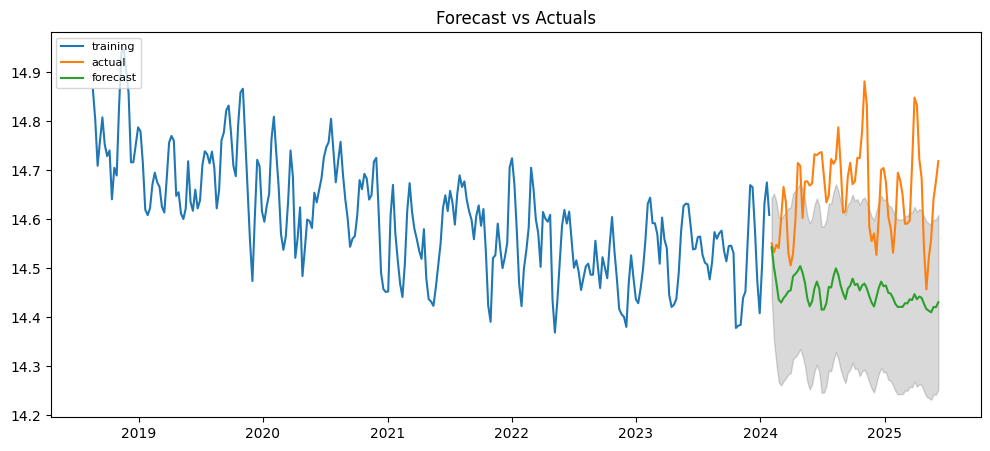

In [29]:

lower_series = conf_int[:,0]
upper_series = conf_int[:,1]

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.index, train.mp_concentration, label='training')
plt.plot(test.index, test.mp_concentration, label='actual')
plt.plot(test.index, forecasts, label='forecast')
plt.fill_between(test.index, lower_series, upper_series, 
                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## SARIMAX

## Optuna (RMSE)

In [7]:
%pip install optuna

You should consider upgrading via the '/usr/local/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import optuna

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
import pandas as pd
import numpy as np
import optuna
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


def objective(trial):
    p = trial.suggest_int('p',0, 3 )
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 3 )

    P = trial.suggest_int('P', 0, 3 )
    D = trial.suggest_int('D', 0, 2)
    Q = trial.suggest_int('Q',0, 2 )

    m = 12

    model =  SARIMAX(train, 
                        order=(p,d,q),
                        seasonal_order=(P,D,Q,m),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit()
        
    forecasts = model.forecast(len(test))

    rmse = np.sqrt(mean_squared_error(test.mp_concentration, forecasts))

    return rmse 


In [33]:
study = optuna.create_study(direction='minimize')

[I 2025-07-18 14:26:51,006] A new study created in memory with name: no-name-0f124678-6756-4880-9c00-e04f0ba1fd32


In [34]:
study.optimize(objective, n_trials=75)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

[I 2025-07-18 14:26:54,503] Trial 0 finished with value: 0.13869909833424696 and parameters: {'p': 1, 'd': 1, 'q': 1, 'P': 3, 'D': 0, 'Q': 1}. Best is trial 0 with value: 0.13869909833424696.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information w

In [35]:
study.best_params

{'p': 0, 'd': 1, 'q': 0, 'P': 0, 'D': 2, 'Q': 2}

In [36]:
best_params = study.best_params

In [37]:
import matplotlib.pyplot as plt
optuna.visualization.plot_optimization_history(study)

In [38]:
optuna.visualization.plot_parallel_coordinate(study)

In [40]:
optuna.visualization.plot_slice(study,params=['p','d','q','P','D','Q'])

In [43]:
optuna.visualization.plot_param_importances(study)

In [44]:
best_p = best_params['p']
best_d = best_params['d']
best_q = best_params['q']
best_P = best_params['P']
best_D = best_params['D']
best_Q = best_params['Q']

In [ ]:
optimal_model = SARIMAX(train, 
                        order=(best_p, best_d, best_q),
                        seasonal_order=(best_P, best_D, best_Q, 12)).fit()

optimal_forecasts = optimal_model.forecast(len(test))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



In [48]:
optimal_forecasts

2024-02-04    14.615773
2024-02-11    14.606963
2024-02-18    14.610148
2024-02-25    14.605541
2024-03-03    14.591306
                ...    
2025-05-11    14.702485
2025-05-18    14.719719
2025-05-25    14.770840
2025-06-01    14.782560
2025-06-08    14.795726
Freq: W-SUN, Name: predicted_mean, Length: 71, dtype: float64

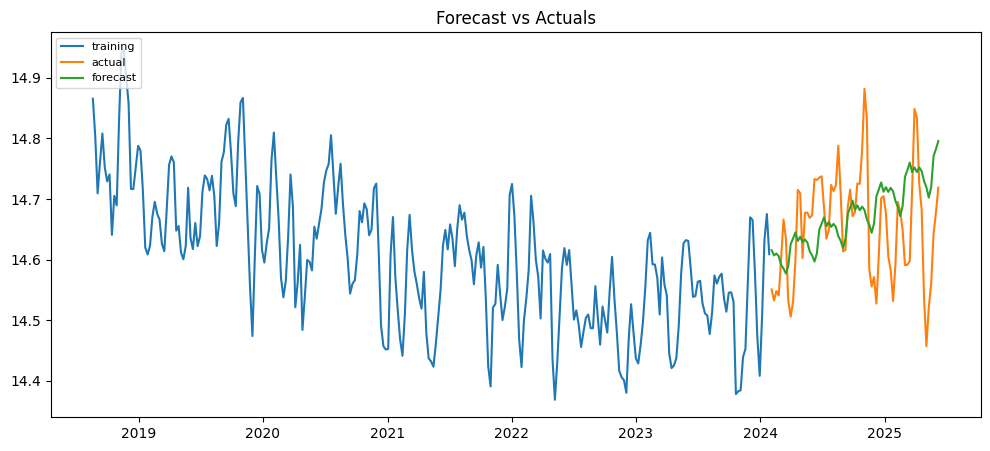

In [49]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.index, train.mp_concentration, label='training')
plt.plot(test.index, test.mp_concentration, label='actual')
plt.plot(test.index, optimal_forecasts, label='forecast')
#plt.fill_between(test.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Optuna SMAPE

In [57]:
def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (sMAPE).
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100
    
def objective(trial):
    p = trial.suggest_int('p',0, 3 )
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 3 )

    P = trial.suggest_int('P', 0, 3 )
    D = trial.suggest_int('D', 0, 2)
    Q = trial.suggest_int('Q',0, 2 )

    m = 12

    model =  SARIMAX(train, 
                        order=(p,d,q),
                        seasonal_order=(P,D,Q,m),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit()
        
    forecasts = model.forecast(len(test))

    sm_ape = smape(test.mp_concentration, forecasts)

    return sm_ape 


In [58]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2025-07-18 14:42:52,891] A new study created in memory with name: no-name-db08a248-2320-4a6d-af5d-b545c9315c6e
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

[I 2025-07-18 14:42:58,181] Trial 0 finished with value: 0.8432497418551016 and parameters: {'p': 1, 'd': 0, 'q': 1, 'P': 3, 'D': 1, 'Q': 1}. Best is trial 0 with value: 0.8432497418551016.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python

In [ ]:
best_params = study.best_params
best_params

{'p': 3, 'd': 0, 'q': 3, 'P': 0, 'D': 0, 'Q': 2}

In [65]:
optuna.visualization.plot_optimization_history(study)


In [62]:
optuna.visualization.plot_parallel_coordinate(study)


In [63]:
optuna.visualization.plot_slice(study, params=['p','d', 'q', 'P', 'Q', 'D'])

In [64]:
optuna.visualization.plot_param_importances(study)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: Con

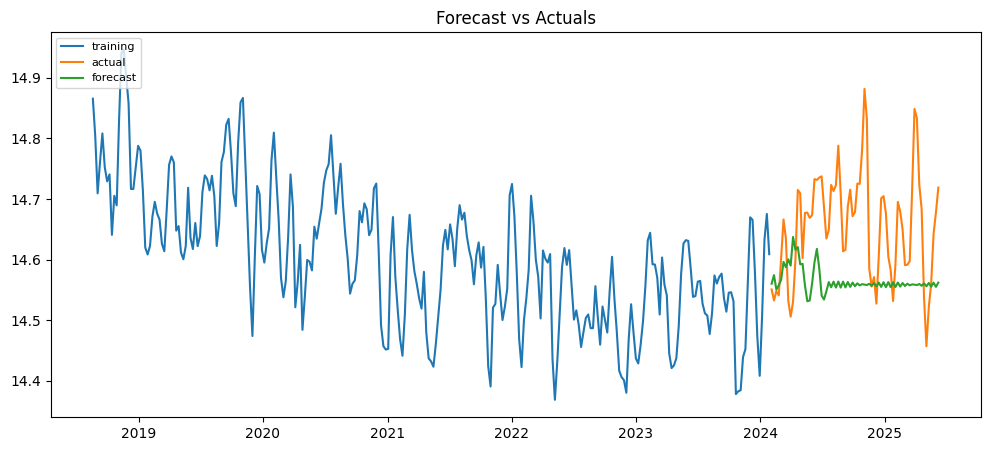

In [66]:
best_p = best_params['p']
best_d = best_params['d']
best_q = best_params['q']
best_P = best_params['P']
best_D = best_params['D']
best_Q = best_params['Q']

optimal_model = SARIMAX(train, 
                        order=(best_p, best_d, best_q),
                        seasonal_order=(best_P, best_D, best_Q, 12)).fit()

optimal_forecasts = optimal_model.forecast(len(test))

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.index, train.mp_concentration, label='training')
plt.plot(test.index, test.mp_concentration, label='actual')
plt.plot(test.index, optimal_forecasts, label='forecast')
#plt.fill_between(test.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()